<a href="https://colab.research.google.com/github/ShraddhaSharma24/Deep-Learning/blob/main/Skin_Cancer_Classification_using_MobileNetV2_%26_TensorFlow_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning-Based Skin Cancer Classification for Edge Deployment

In [3]:
import os
import shutil
import zipfile
import os

dataset_path = "/kaggle/input/skin-cancer-mnist-ham10000"  # Change this if your dataset name is different
print("Dataset Path:", dataset_path)



Dataset Path: /kaggle/input/skin-cancer-mnist-ham10000


In [11]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shraddhasharmaa","key":"f02a07e87fdfb9fa2cd3692ea612b408"}'}

In [12]:
import os

# Make a directory for Kaggle API
!mkdir -p ~/.kaggle

# Move kaggle.json to this directory
!mv kaggle.json ~/.kaggle/

# Change file permissions to prevent security issues
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
# Install Kaggle API if not already installed
!pip install -q kaggle

# Download dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip dataset
!unzip -q skin-cancer-mnist-ham10000.zip -d skin_cancer_data

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [00:25<00:00, 318MB/s]
100% 5.20G/5.20G [00:25<00:00, 218MB/s]


In [14]:
import os

# Set dataset path
dataset_path = "skin_cancer_data"

# List files in dataset folder
print("Available files:", os.listdir(dataset_path))

Available files: ['hmnist_8_8_L.csv', 'HAM10000_metadata.csv', 'HAM10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_1', 'hmnist_8_8_RGB.csv', 'ham10000_images_part_2', 'HAM10000_images_part_1']


In [15]:
import pandas as pd

metadata_path = os.path.join(dataset_path, "HAM10000_metadata.csv")
df = pd.read_csv(metadata_path)

print(df.head())  # Display first few rows

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [16]:
image_path_1 = os.path.join(dataset_path, "HAM10000_images_part_1")
image_path_2 = os.path.join(dataset_path, "HAM10000_images_part_2")

df["image_path"] = df["image_id"].apply(lambda x:
    os.path.join(image_path_1, x + ".jpg") if os.path.exists(os.path.join(image_path_1, x + ".jpg"))
    else os.path.join(image_path_2, x + ".jpg"))

print(df["image_path"].head())

0    skin_cancer_data/HAM10000_images_part_1/ISIC_0...
1    skin_cancer_data/HAM10000_images_part_1/ISIC_0...
2    skin_cancer_data/HAM10000_images_part_1/ISIC_0...
3    skin_cancer_data/HAM10000_images_part_1/ISIC_0...
4    skin_cancer_data/HAM10000_images_part_2/ISIC_0...
Name: image_path, dtype: object


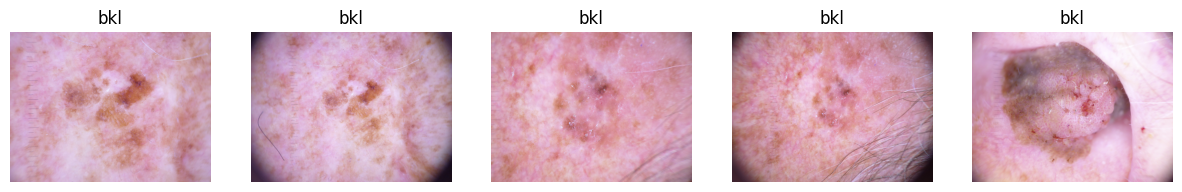

In [17]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Define function to display images
def display_images(df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        img_path = df.iloc[i]["image_path"]
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(df.iloc[i]["dx"])  # Show label

    plt.show()

# Show 5 images
display_images(df)


In [18]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Define image size
IMG_SIZE = 128  # Resize all images to 128x128

# Load images and labels
X = []
y = []

for i, row in df.iterrows():
    img = load_img(row["image_path"], target_size=(IMG_SIZE, IMG_SIZE))  # Resize
    img_array = img_to_array(img) / 255.0  # Normalize
    X.append(img_array)
    y.append(row["dx"])  # Label

# Convert to NumPy arrays
X = np.array(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert labels to numbers
y_categorical = to_categorical(y_encoded)  # One-hot encode

# Print label mapping
print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


Label Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [19]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (8012, 128, 128, 3) Test shape: (2003, 128, 128, 3)


Build a CNN Model

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation="softmax")  # Output layer
])

# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [21]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6391 - loss: 1.1487 - val_accuracy: 0.6680 - val_loss: 0.9641
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.6639 - loss: 0.9626 - val_accuracy: 0.6500 - val_loss: 0.9192
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6780 - loss: 0.8904 - val_accuracy: 0.6725 - val_loss: 0.8503
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6803 - loss: 0.8551 - val_accuracy: 0.6925 - val_loss: 0.8245
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6946 - loss: 0.8307 - val_accuracy: 0.7039 - val_loss: 0.7979
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7127 - loss: 0.7744 - val_accuracy: 0.7114 - val_loss: 0.7879
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7141 - loss: 0.7608 - val_accuracy: 0.7054 - val_loss: 0.8027
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7213 - loss: 0.7524 - val_acc

Evaluate the Model

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7148 - loss: 0.7740
Test Accuracy: 0.72


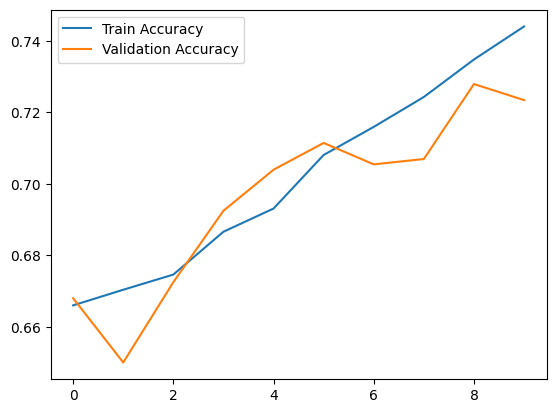

In [22]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training history
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.show()


Load Pretrained MobileNetV2

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load MobileNetV2 with pretrained weights (excluding top layer)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output_layer = Dense(len(label_encoder.classes_), activation="softmax")(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Train the Model

In [24]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.6686 - loss: 0.9879 - val_accuracy: 0.7294 - val_loss: 0.7601
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7447 - loss: 0.7268 - val_accuracy: 0.7389 - val_loss: 0.7147
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7693 - loss: 0.6754 - val_accuracy: 0.7349 - val_loss: 0.7108
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7831 - loss: 0.6178 - val_accuracy: 0.7404 - val_loss: 0.6977
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7854 - loss: 0.5808 - val_accuracy: 0.7384 - val_loss: 0.6814
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7987 - loss: 0.5607 - val_accuracy: 0.7549 - val_loss: 0.6740
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7989 - loss: 0.5382 - val_accuracy: 0.7469 - val_loss: 0.6726
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8090 - loss: 0.5194 - val_acc

Evaluate and Save the Model

In [25]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# Save the trained model
model.save("mobilenet_skin_cancer.h5")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7376 - loss: 0.7051


Test Accuracy: 0.75


 Deployment on Edge Devices
 Convert Model to TensorFlow Lite

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open("mobilenet_skin_cancer.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpv7ca9upd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138824224506320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224509968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224510352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224510160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224505936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224508624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224506128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224520336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224508816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224509392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13882422450

Running Inference with TFLite

In [30]:
import tensorflow.lite as tflite
import numpy as np
from PIL import Image

# Load the TFLite model
interpreter = tflite.Interpreter(model_path="mobilenet_skin_cancer.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess an image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0).astype(np.float32)
    return img

# Run inference
def predict(image_path):
    img = preprocess_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output_data)

    return label_encoder.inverse_transform([predicted_label])[0]

# Test with an image
print(predict("test_image_path.jpg"))


FileNotFoundError: [Errno 2] No such file or directory: 'test_image_path.jpg'

In [28]:
test_image_path = df.iloc[0]["image_path"]  # Pick the first image from the dataset
print(f"Testing with: {test_image_path}")

print(predict(test_image_path))

Testing with: skin_cancer_data/HAM10000_images_part_1/ISIC_0027419.jpg
nv


Improve Model Performance

In [31]:
# Unfreeze some layers of the MobileNetV2 model
base_model.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Fine-tune the model
history_finetune = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 92s 170ms/step - accuracy: 0.6594 - loss: 2.1208 - val_accuracy: 0.7009 - val_loss: 1.6728
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6920 - loss: 1.0842 - val_accuracy: 0.6795 - val_loss: 2.6638
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7284 - loss: 0.8404 - val_accuracy: 0.6830 - val_loss: 2.7351
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7386 - loss: 0.7659 - val_accuracy: 0.6825 - val_loss: 2.8332
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.7617 - loss: 0.6556 - val_accuracy: 0.6835 - val_loss: 2.6073


Optimize the Model for Deployment

In [32]:
# Convert to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable quantization
tflite_quant_model = converter.convert()

# Save the quantized model
with open("mobilenet_skin_cancer_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("Quantized TFLite model saved!")


Saved artifact at '/tmp/tmp_a7g88wp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  138824224506320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224509968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224510352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224510160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224505936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224508624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224506128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224520336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224508816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138824224509392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13882422450

Deploy as a Web App

In [34]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [35]:
import gradio as gr

# Define a Gradio interface
def classify_skin_cancer(image):
    pred_label = predict(image)
    return f"Predicted Class: {pred_label}"

iface = gr.Interface(fn=classify_skin_cancer, inputs="image", outputs="text")
iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://098129747e05eed2d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
